# Imports

In [1]:
import os, errno

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import mlflow
import mlflow.sklearn

from IPython.display import display, HTML

# Function Definitions

In [2]:
def makedirs(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [3]:
def download_wine(basename, dirname):
    print("downloading wine dataset")
    data = datasets.load_wine(as_frame=True)
    df = data.frame
    targets = df.columns[~np.in1d(df.columns,data.feature_names)]
    df[targets] = data.target_names[df[targets]]
    print(data.target_names)
    makedirs(dirname)
    with open(os.path.join(dirname, basename), "w") as fp:
        df.to_csv(fp)

In [4]:
def load_wine(basename="data.csv", dirname="./datasets/wine"):
    if not os.path.exists( os.path.join(dirname, basename) ):
        download_wine(basename, dirname)
    with open(os.path.join(dirname, basename)) as fp:
        dataset_df = pd.read_csv(fp, index_col=0)
    return dataset_df

# K Nearest Neighbor

In [5]:
def train_knn(n_neighbors=5, weights="uniform"):
    # set the name of this run within the experiment
    run_name = "KNN({}, {}) - Advanced MLFlow".format(n_neighbors, weights)
    with mlflow.start_run(run_name=run_name) as run:
        # load dataset
        dataset_df = load_wine()
        X = dataset_df[dataset_df.columns[:-1]]
        y = dataset_df[dataset_df.columns[-1]]
        
        # create train/test splits
        splits = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True, stratify=y)
        X_train, X_test, y_train, y_test = splits

        # build classifier
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        knn.fit(X_train, y_train)

        # save model parameters
        params = knn.get_params()
        mlflow.log_params(params)

        # evaluate performance
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        metrics = precision_recall_fscore_support(y_test, y_pred, average="macro")
        precision, recall, fscore, support = metrics
        print("{1:10.4f} {0:}".format("Accuracy",  accuracy))
        print("{1:10.4f} {0:}".format("Precision", precision))
        print("{1:10.4f} {0:}".format("Recall",    recall))
        print("{1:10.4f} {0:}".format("Fscore",    fscore))
        
        disp = plot_confusion_matrix(knn, X_test, y_test, display_labels=None, include_values=True, xticks_rotation=40, values_format=None, cmap="Blues", ax=None)
        disp.ax_.set_xticklabels(dataset_df["target"].unique(), rotation=40, ha="right")
        disp.ax_.set_title( "{} Confusion Matrix".format(knn.__class__.__name__) )
        disp.ax_.set_xlabel("Predicted")
        disp.ax_.set_ylabel("Acutal")
        plt.tight_layout()
        plt.savefig("./confusion_matrix.png", dpi=1200)
        plt.show()
        mlflow.log_artifact("./confusion_matrix.png")
        
        # save performance metrics
        metrics = {"accuracy":accuracy, "precision":precision, "recall":recall, "fscore":fscore}
        mlflow.log_metrics(metrics)

        # save the trained model
        mlflow.sklearn.log_model(knn, "model")

# Run Experiments

## Default Local Storage

By default, the MLflow Python API logs runs locally to files in a `mlruns` directory wherever you ran your program. You can see the logged runs by running the `mlflow ui` command in the same directory as your code and then viewing the following webpage: http://localhost:5000

tracking location: file:///Users/rina/Documents/Rubicon/Tutorial/mlruns

KNN, n_neighbors=1
    0.7111 Accuracy
    0.7324 Precision
    0.7000 Recall
    0.7033 Fscore


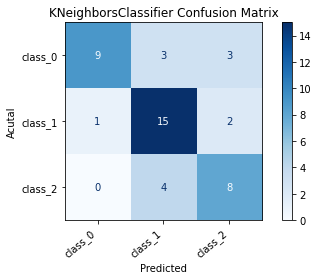

In [6]:
print("tracking location:", mlflow.tracking.get_tracking_uri() )

# set the mlflow experiment
mlflow.set_experiment("Wine (Default Local Storage)")
print()

print("KNN, n_neighbors=1")
train_knn(n_neighbors=1)

## User-Defined Local Storage


MLflow Python API function [`mlflow.tracking.set_tracking_uri`](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.set_tracking_uri) can be used to change the location of logged runs. To change the local directory used to log runs, a local file path, prefixed with `file:/` can be passed to the `mlflow.tracking.set_tracking_uri` function.  For example, `mlflow.tracking.set_tracking_uri("file:./advanced_mlruns")`

The `--backend-store-uri` option to the `mlflow ui` command is used to view logs saved to user-specified directories. For example, `mlflow ui --backend-store-uri ./advanced_mlruns`.

http://localhost:5000

tracking location: file:./advanced_mlruns

KNN, n_neighbors=5, weights=uniform
    0.6667 Accuracy
    0.6416 Precision
    0.6537 Recall
    0.6417 Fscore


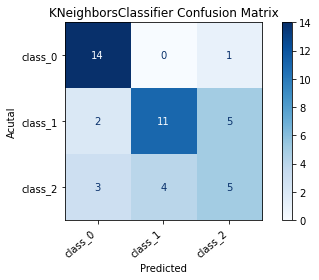

In [7]:
mlflow.tracking.set_tracking_uri("file:./advanced_mlruns")
print("tracking location:", mlflow.tracking.get_tracking_uri() )

# set the mlflow experiment
mlflow.set_experiment("Wine (User-Defined Local Storage)")
print()

print("KNN, n_neighbors=5, weights=uniform")
train_knn(n_neighbors=5, weights="uniform")

## Remote Storage

The [`mlflow.tracking.set_tracking_uri`](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.set_tracking_uri) can also be used to log runs remotely by providing an HTTP URL string(remote server link). An MLFlow server must be running on the host and port specified by the URL. The `mlflow server` command can be used to start an MLFlow server.  The `--host` option can be used to change the default network address interface used (`127.0.0.1` by default, `0.0.0.0` for all addresses), while the `--port` option is used to change the default port. The `--backend-store-uri` option is used to specify the location the server uses to save runs.  For example, `mlflow server --host 0.0.0.0 --port 80 --backend-store-uri ./online_mlruns`.

In addition to logging runs, the MLFlow server can also be used to view the runs, just like with the `mlflow ui` command.


https://github.com/mlflow/mlflow/issues/572#issuecomment-427718078

tracking location: http://35.173.191.133:5000

KNN, n_neighbors=1
    0.7111 Accuracy
    0.7324 Precision
    0.7000 Recall
    0.7033 Fscore


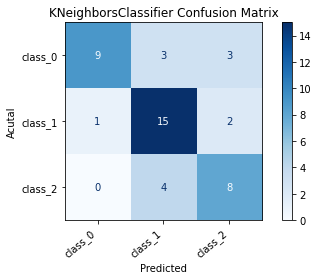


KNN, n_neighbors=5, weights=uniform
    0.6667 Accuracy
    0.6416 Precision
    0.6537 Recall
    0.6417 Fscore


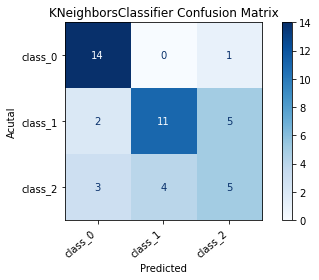


KNN, n_neighbors=5, weights=distance
    0.6444 Accuracy
    0.6772 Precision
    0.6444 Recall
    0.6467 Fscore


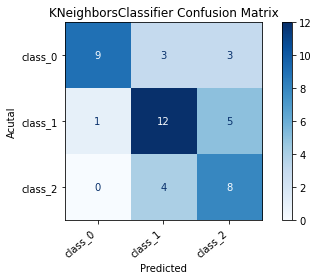

In [8]:
mlflow.tracking.set_tracking_uri("remote server link")
print("tracking location:", mlflow.tracking.get_tracking_uri() )

# set the mlflow experiment
mlflow.set_experiment("Wine (Fusemachines tutorial)")
print()

print("KNN, n_neighbors=1")
train_knn(n_neighbors=1)
print()

print("KNN, n_neighbors=5, weights=uniform")
train_knn(n_neighbors=5, weights="uniform")
print()

print("KNN, n_neighbors=5, weights=distance")
train_knn(n_neighbors=5, weights="distance")